In [ ]:
pip install underthesea keras-tuner tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import underthesea
import nltk
nltk.download('vader_lexicon')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,  f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter
import seaborn as sns
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
import time
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def read_excel_file(file_path):
  try:
    df = pd.read_excel(file_path, engine='openpyxl')
    return df
  except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    return None
  except Exception as e:
    print(f"An error occurred: {e}")
    return None

# Example usage:
file_path = '/content/FinalReview.xlsx'
df = read_excel_file(file_path)
df.head()

,City Name,Review,Label
0,Đà Lạt,- Là 1 người sg chính hiệu nhưng lại muốn trở ...,positive
1,Đà Lạt,Mình thề với tầm giá tiền như thế này không th...,positive
2,Đà Lạt,"Chỗ nghỉ nhỏ nhắn, ấm cúng, đồ dùng thì đầy đủ...",positive
3,Đà Lạt,Sạch sẽ tiện nghi dù đi một mình hay với gia đ...,positive
4,Đà Lạt,"Với giá rẻ dưới 100k, phòng Dorm thế này thì t...",positive


Thăm dò dữ liệu EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3165 entries, 0 to 3164
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   City Name  3165 non-null   object
 1   Review     3165 non-null   object
 2   Label      3165 non-null   object
dtypes: object(3)
memory usage: 74.3+ KB


In [ ]:
print("\nGiá trị NaN trong mỗi cột:")
print(df.isna().sum())


Giá trị NaN trong mỗi cột:
City Name    0
Review       0
Label        0
dtype: int64


In [ ]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]

if not duplicate_rows.empty:
    print("\nCác hàng trùng lặp:")
    print(duplicate_rows)
else:
    print("\nKhông có hàng trùng lặp nào được tìm thấy.")
df = df.drop_duplicates()

# Print some info
print("\nDataFrame sau khi xóa các hàng trùng lặp:")
print(df.info())


Các hàng trùng lặp:
     City Name                                             Review     Label
14      Đà Lạt  Mình ở đây 3 đêm rất thích, phòng ngăn nắp và ...  positive
60      Đà Lạt                                                 Ok  positive
211     Đà Lạt  70% sự hài lòng” Mình book trên app nên có phò...  positive
276     Đà Lạt                                                 Ok  positive
310     Đà Lạt                                                 Ok  positive
...        ...                                                ...       ...
2979    Hà Nội   Vị trí vào khó tìm, phòng nhỏ, bẩn và nv thái độ  negative
2980    Hà Nội  Phòng dột từ giường ngủ dột ra, điều hoà cũ kh...  negative
3075    Hà Nội                                            Rất tốt  positive
3090    Hà Nội                                             Tạm ổn  positive
3161    Hà Nội                                                 Ok  positive

[159 rows x 3 columns]

DataFrame sau khi xóa các hàng trùng lặp:


In [ ]:
df_group_label = df.groupby('Label')['Label'].count()
df_group_label

,Label
Label,
negative,949
positive,2057


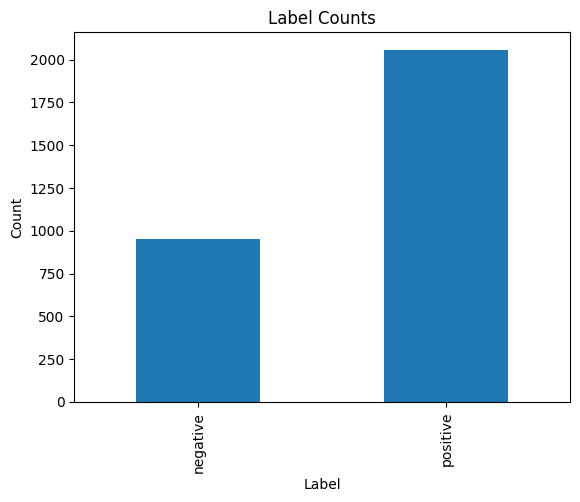

In [ ]:
df_group_label.plot(kind='bar')
plt.title('Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

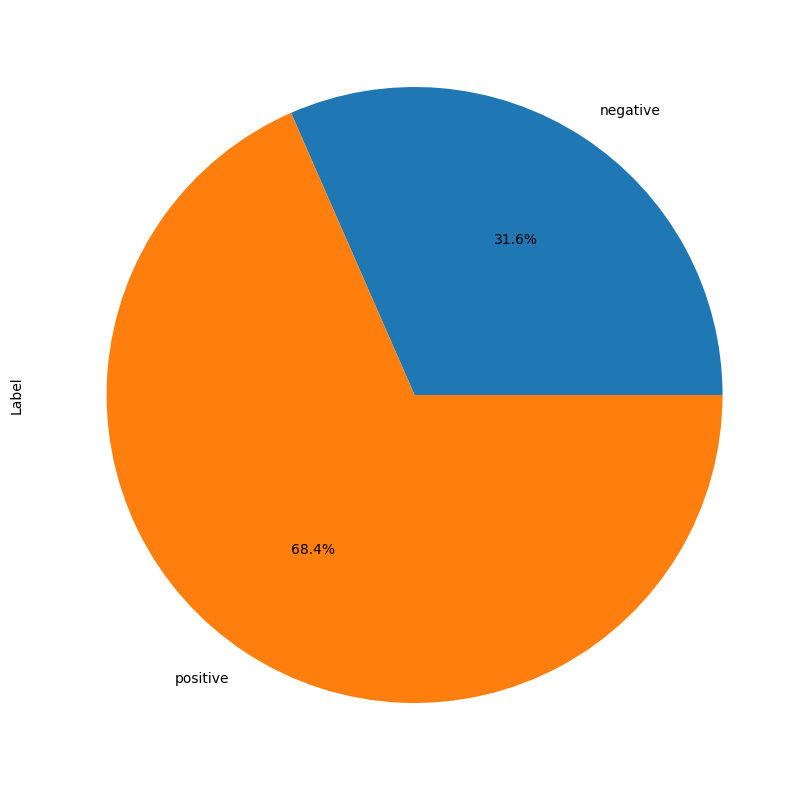

In [ ]:
df_group_label.plot.pie(figsize=(10,10),autopct='%1.1f%%')
plt.show()

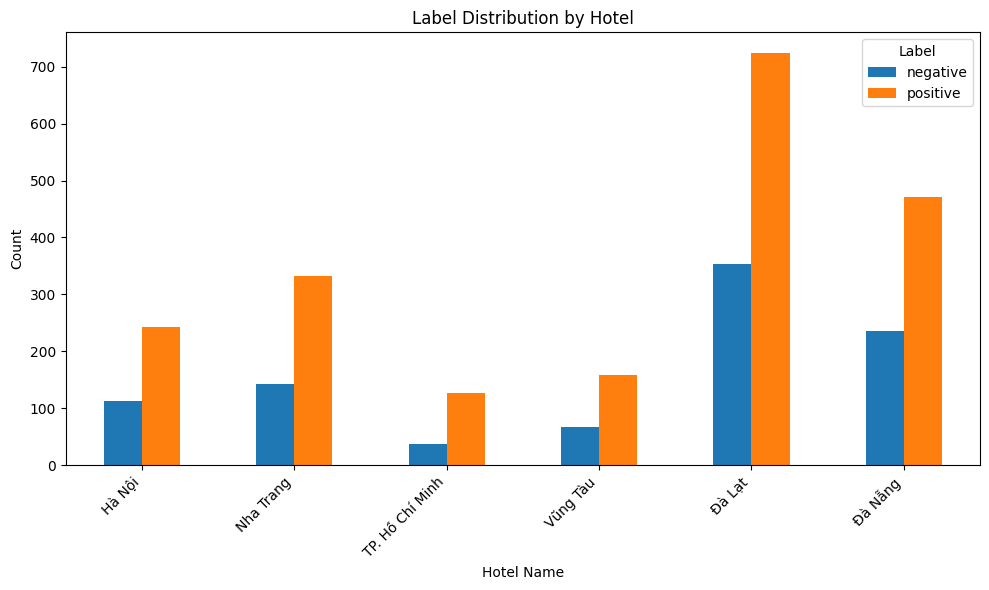

In [ ]:
df_group_city = df.groupby('City Name')['Label'].value_counts().unstack(fill_value=0)
df_group_city.plot(kind='bar', figsize=(10, 6))
plt.title('Label Distribution by Hotel')
plt.xlabel('Hotel Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Label')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


Tiền xử lý dữ liệu

In [ ]:
def load_dict(file_path, delimiter='\t'):
    try:
        with open(file_path, 'r', encoding="utf8") as file:
            lines = file.read().split('\n')
            return {key: value for key, value in (line.split(delimiter) for line in lines if line.strip())}
    except FileNotFoundError:
        print(f"File {file_path} không tồn tại.")
        return {}
    except ValueError:
        print(f"Lỗi định dạng trong {file_path}.")
        return {}

def load_list(file_path):
    try:
        with open(file_path, 'r', encoding="utf8") as file:
            return [line.strip() for line in file if line.strip()]
    except FileNotFoundError:
        print(f"File {file_path} không tồn tại.")
        return []

# Load dữ liệu
emoji_dict = load_dict('/content/emojicon.txt')
teen_dict = load_dict('/content/teencode.txt')
stopwords_lst = load_list('/content/vietnamese-stopwords (1).txt')


In [ ]:
def convert_emoji(sentence, emoji_dict):
    return ''.join(' '+emoji_dict[word]+' ' if word in emoji_dict else word for word in list(sentence))

def remove_punctuation(sentence):
    pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
    return ' '.join(regex.findall(pattern, sentence))

def convert_teencode(sentence, teen_dict):
    return ' '.join(teen_dict[word] if word in teen_dict else word for word in sentence.split())

def remove_stopwords(sentence, stopwords):
    # Tách câu thành các từ, loại bỏ các stopwords
    return ' '.join([word for word in sentence.split() if word not in stopwords])


In [ ]:
def process_text(text, emoji_dict, teen_dict,stopwords_lst):
    document = text.lower()
    document = document.replace("’",'')
    document = regex.sub(r'\.+', ".", document)
    new_sentence = ''

    for sentence in sent_tokenize(document):
        sentence = convert_emoji(sentence, emoji_dict)
        sentence = remove_punctuation(sentence)
        sentence = convert_teencode(sentence, teen_dict)
        sentence = remove_stopwords(sentence, stopwords_lst)
        new_sentence += sentence + ' '

    document = regex.sub(r'\s+', ' ', new_sentence).strip()
    document = regex.sub(r'([a-z])\1+', lambda m: m.group(1).lower(), document, flags=regex.IGNORECASE)
    return document


In [ ]:
# Apply the process_text function to the 'Review' column
df['Review'] = df['Review'].apply(lambda x: process_text(x, emoji_dict, teen_dict,stopwords_lst))

# Now you can access the processed reviews in the 'Processed_Review' column
print(df[['Review']].head())

                                              Review
0  sài gòn hiệu trở thành đà lạt phòng tập thể hơ...
1  thề tầm giá tiền thể chỗ phòng xịn sạch ấm áp ...
2  chỗ nghỉ nhắn ấm cúng đồ lắm phòng nvs sạch lắ...
3            sạch tiện nghi đi gia đình hội ghé tiếp
4  giá rẻ phòng dorm tuyệt vời sạch wifi hơi đông...


In [ ]:
df.head()

,City Name,Review,Label
0,Đà Lạt,sài gòn hiệu trở thành đà lạt phòng tập thể hơ...,positive
1,Đà Lạt,thề tầm giá tiền thể chỗ phòng xịn sạch ấm áp ...,positive
2,Đà Lạt,chỗ nghỉ nhắn ấm cúng đồ lắm phòng nvs sạch lắ...,positive
3,Đà Lạt,sạch tiện nghi đi gia đình hội ghé tiếp,positive
4,Đà Lạt,giá rẻ phòng dorm tuyệt vời sạch wifi hơi đông...,positive


In [ ]:
def tokenize_review(review):
    return word_tokenize(review)

df['tokenized_review'] = df['Review'].apply(tokenize_review)
print(df[['tokenized_review']].head())

                                    tokenized_review
0  [sài, gòn hiệu, trở thành, đà, lạt, phòng, tập...
1  [thề, tầm, giá, tiền thể, chỗ, phòng, xịn, sạc...
2  [chỗ, nghỉ, nhắn, ấm cúng, đồ, lắm, phòng, nvs...
3    [sạch, tiện nghi, đi, gia đình, hội, ghé, tiếp]
4  [giá, rẻ, phòng, dorm, tuyệt vời, sạch, wifi, ...


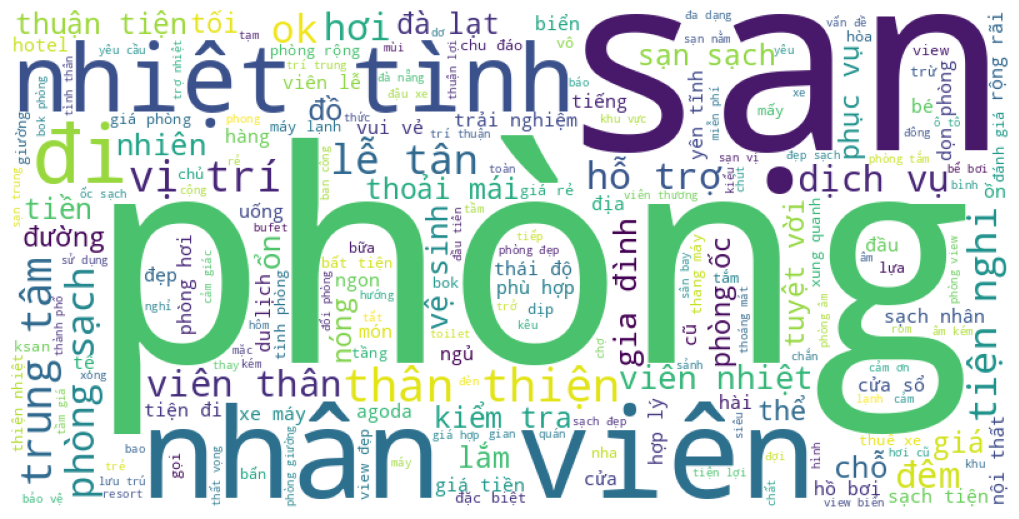

In [ ]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all tokenized reviews into a single string
all_words = ' '.join([' '.join(tokens) for tokens in df['tokenized_review']])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display the generated image:
plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
tokenized_reviews_list = df['tokenized_review'].tolist()
print(tokenized_reviews_list[:5]) # Print the first 5 elements of the list

[['sài', 'gòn hiệu', 'trở thành', 'đà', 'lạt', 'phòng', 'tập thể', 'hơi', 'bất tiện', 'sạch', 'ấm cúng', 'tiện nghi', 'ngăn đồ', 'ban', 'công phòng', 'thư giãn', 'khu', 'sinh hoạt', 'sân thượng roftop', 'uống', 'cf', 'ngắm', 'bình minh', 'hoàng hôn', 'đi', 'du lịch', 'tiết kiệm', 'xứng'], ['thề', 'tầm', 'giá', 'tiền thể', 'chỗ', 'phòng', 'xịn', 'sạch', 'ấm áp', 'đi', 'du lịch', 'mấy', 'chỗ', 'phong thủy', 'ngủ', 'bóng', 'đè', 'ngủ', 'john', 'giường', 'tẩm', 'đá', 'ngủ', 'ngon', 'lắm', 'chỗ', 'trung tâm', 'mấy', 'hàng', 'ngon', 'toàn', 'quanh', 'phường', 'highly', 'đề xuất'], ['chỗ', 'nghỉ', 'nhắn', 'ấm cúng', 'đồ', 'lắm', 'phòng', 'nvs', 'sạch', 'lắm', 'chủ', 'dọn', 'vị trí', 'khu', 'lẩu', 'bò', 'hoàng diệu', 'đồ', 'chợ', 'đà lạt', 'khu', 'quen', 'đường', 'đi', 'thoải mái', 'lắm', 'chủ', 'hỗ trợ', 'nhiệt tình', 'gu', 'decor', 'chỗ', 'nghỉ', 'ưng', 'kiểu', 'nét', 'thú vị', 'lắm', 'giá', 'hợp lý', 'đi', 'gia đình', 'ghé', 'đà', 'lạt', 'john', 'tiếp'], ['sạch', 'tiện nghi', 'đi', 'gia đìn

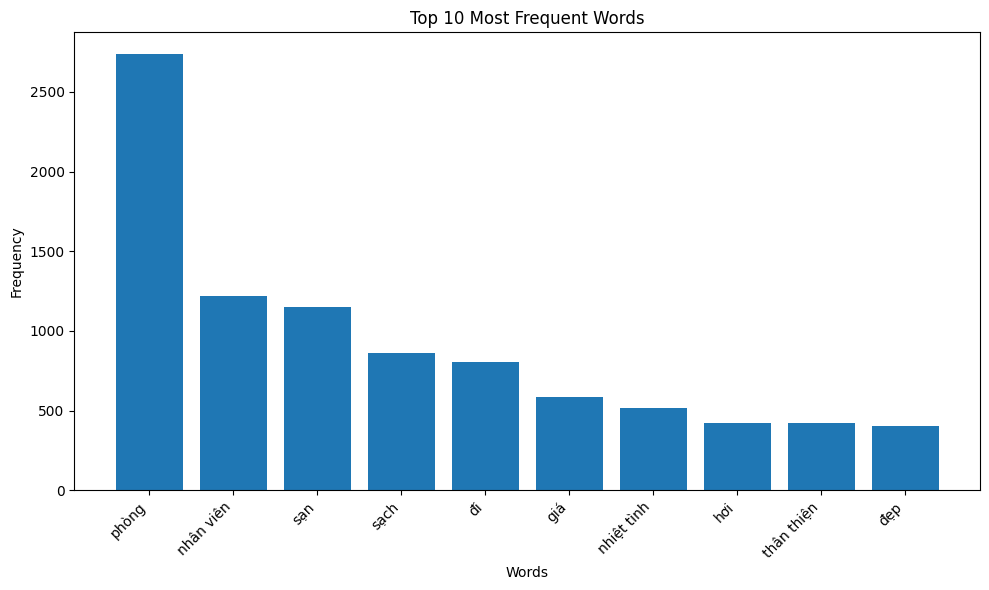

In [ ]:
# Flatten the list of lists into a single list of tokens
all_tokens = [token for sublist in tokenized_reviews_list for token in sublist]

# Count the frequency of each token
word_counts = Counter(all_tokens)

# Get the top 10 most frequent words
top_10_words = word_counts.most_common(10)

# Extract words and counts for plotting
words = [word for word, count in top_10_words]
counts = [count for word, count in top_10_words]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 10 Most Frequent Words")
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

SUBJECTIVITY

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


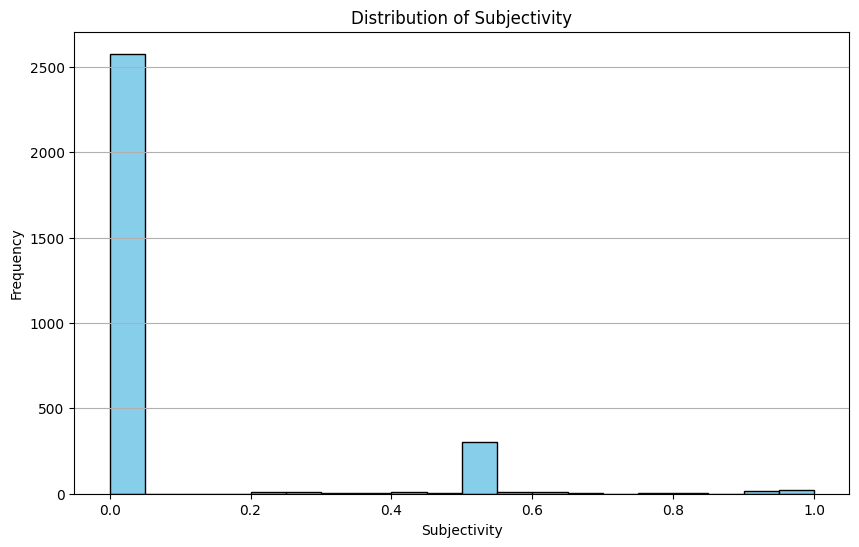

In [ ]:
# Bước 1: Gắn Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Đường dẫn đến tệp
file_path = '/content/drive/My Drive/[NLP] Nhóm 10/[CUỐI KÌ]/Final_NLP_Data.xlsx'
df = pd.read_excel(file_path)

# Bước 3: Cài đặt TextBlob và Matplotlib
!pip install textblob
import matplotlib.pyplot as plt
from textblob import TextBlob

# Bước 4: Định nghĩa hàm calculate_subjectivity
def calculate_subjectivity(reviews):
    """Tính toán subjectivity từ danh sách các nhận xét và vẽ biểu đồ."""
    subjectivities = []

    for review in reviews:
        blob = TextBlob(review)
        subjectivities.append(blob.sentiment.subjectivity)

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    plt.hist(subjectivities, bins=20, color='skyblue', edgecolor='black')
    plt.title("Distribution of Subjectivity")
    plt.xlabel("Subjectivity")
    plt.ylabel("Frequency")
    plt.grid(axis='y')

    # Hiển thị biểu đồ
    plt.show()

# Bước 5: Lấy cột 'Review'
reviews = df['Review'].dropna().tolist()  # Loại bỏ giá trị NaN

# Bước 6: Gọi hàm để tính subjectivity và vẽ biểu đồ
calculate_subjectivity(reviews)

COMPOUND SCORE

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                              Review  Compound Score
0  là người sài gòn chính hiệu nhưng lại muốn trở...         -0.5574
1  mình thề với tầm giá tiền như thế này không th...          0.0000
2  chỗ nghỉ nhỏ nhắn ấm cúng đồ dùng thì đầy đủ l...          0.0000
3  sạch sẽ tiện nghi dù đi một mình hay với gia đ...          0.0000
4  với giá rẻ dưới phòng dorm thế này thì tuyệt v...          0.0000


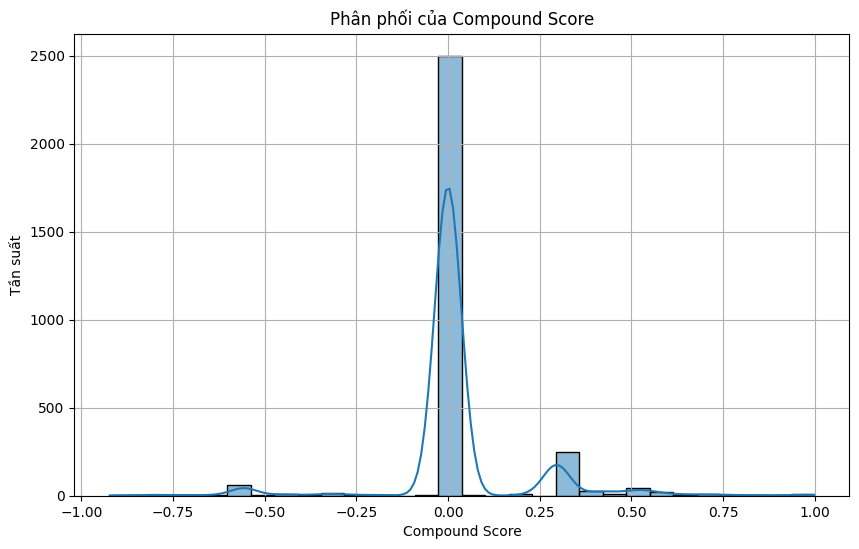

In [ ]:
# Gắn Google Drive
drive.mount('/content/drive')

# Đọc tệp Excel
file_path = '/content/drive/My Drive/[NLP] Nhóm 10/[CUỐI KÌ]/Final_NLP_Data.xlsx'
df = pd.read_excel(file_path)

# Kiểm tra xem cột 'Review' có tồn tại không
if 'Review' not in df.columns:
    raise ValueError("Cột 'Review' không tồn tại trong dữ liệu.")

# Khởi tạo SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Tính toán Compound Score cho từng bình luận
df['Compound Score'] = df['Review'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Hiển thị một số thông tin cơ bản
print(df[['Review', 'Compound Score']].head())

# Vẽ biểu đồ phân phối của Compound Score
plt.figure(figsize=(10, 6))
sns.histplot(df['Compound Score'], bins=30, kde=True)
plt.title('Phân phối của Compound Score')
plt.xlabel('Compound Score')
plt.ylabel('Tần suất')
plt.grid()
plt.show()

Xây dựng mô hình


In [ ]:
df['tokenized_review_str'] = df['tokenized_review'].apply(' '.join)  # Convert the list to a string
X = df['tokenized_review_str']
y = df['Label']

# Vectorize the text data
vector = TfidfVectorizer(analyzer='word', max_features=5000)
x_tfidf = vector.fit_transform(X).toarray()

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(x_tfidf, y_encoded, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))
print("Validation set size:", len(X_val))

Training set size: 2104
Testing set size: 451
Validation set size: 451


              precision    recall  f1-score   support

           0       0.89      0.28      0.43       142
           1       0.75      0.98      0.85       309

    accuracy                           0.76       451
   macro avg       0.82      0.63      0.64       451
weighted avg       0.79      0.76      0.72       451



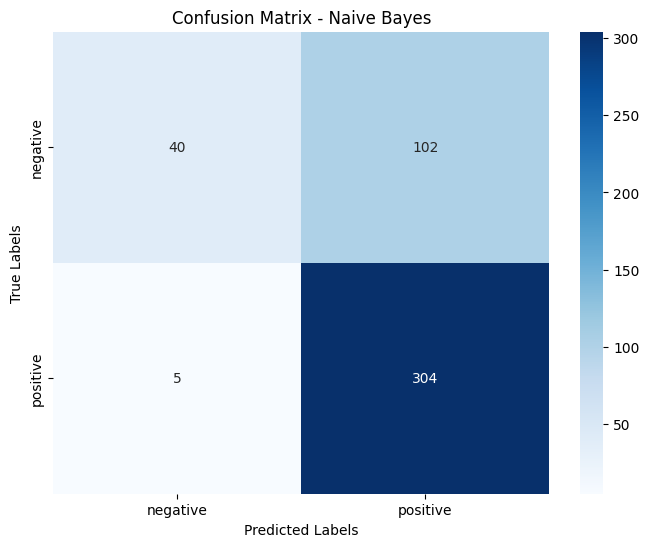

In [ ]:
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_nb = naive_bayes_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_nb)
print(classification_report(y_test, y_pred_nb))


# Create and display the confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid_nb = {
    'alpha': [0.1, 0.25, 0.5, 0.75, 1.0],  # Example values for alpha
}

# Create a GridSearchCV object
grid_search_nb = GridSearchCV(estimator=naive_bayes_model,
                           param_grid=param_grid_nb,
                           cv=5,  # Number of cross-validation folds
                           scoring='accuracy') # or another relevant metric

# Fit the GridSearchCV object to the training data
grid_search_nb.fit(X_train, y_train)


# Print the best hyperparameters and the corresponding score
print("Best hyperparameters:", grid_search_nb.best_params_)
print("Best score:", grid_search_nb.best_score_)


# Dự đoán và đánh giá trên tập kiểm tra
best_model_nb = grid_search_nb.best_estimator_
y_pred_nb = best_model_nb.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f"Test accuracy: {acc_nb}")

# Đánh giá mô hình trên tập Test
print('Classification report: \n', classification_report(y_test, y_pred_nb))

Best hyperparameters: {'alpha': 0.1}
Best score: 0.7984911209139238
Test accuracy: 0.7893569844789357
Classification report: 
               precision    recall  f1-score   support

           0       0.69      0.59      0.64       142
           1       0.82      0.88      0.85       309

    accuracy                           0.79       451
   macro avg       0.76      0.74      0.75       451
weighted avg       0.78      0.79      0.78       451



In [ ]:

def predict_comment(comment):
    # Preprocess the new comment
    comment = process_text(comment, emoji_dict, teen_dict, stopwords_lst)
    comment_tokens = word_tokenize(comment)
    comment_str = " ".join(comment_tokens)

    # Transform the comment using the same vectorizer
    comment_tfidf = vector.transform([comment_str]).toarray()

    # Make the prediction
    prediction = best_model_nb.predict(comment_tfidf)[0]

    # Inverse transform the prediction to get the original label
    predicted_label = label_encoder.inverse_transform([prediction])[0]

    return predicted_label

while True:
    comment = input("Nhập comment (hoặc nhập 'exit' để thoát): ")
    if comment.lower() == 'exit':
        break

    predicted_label = predict_comment(comment)
    print(f"Predicted label for '{comment}': {predicted_label}")

Nhập comment (hoặc nhập 'exit' để thoát): bẩn
Predicted label for 'bẩn': negative
Nhập comment (hoặc nhập 'exit' để thoát): không sạch
Predicted label for 'không sạch': positive
Nhập comment (hoặc nhập 'exit' để thoát): exit


              precision    recall  f1-score   support

           0       0.69      0.60      0.64       142
           1       0.83      0.88      0.85       309

    accuracy                           0.79       451
   macro avg       0.76      0.74      0.75       451
weighted avg       0.78      0.79      0.78       451



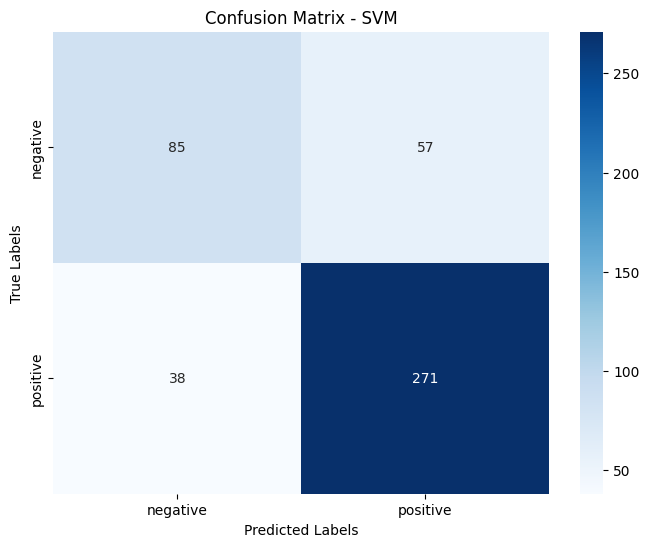

In [ ]:
svm_model = SVC(kernel='linear', C=1) # You can adjust the kernel and C value
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the SVM model
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# Define the parameter grid for GridSearchCV with SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01]
}

# Create a GridSearchCV object for SVM
grid_search_svm = GridSearchCV(estimator=svm_model,
                           param_grid=param_grid_svm,
                           cv=5,  # Number of cross-validation folds
                           scoring='accuracy') # or another relevant metric

# Fit the GridSearchCV object to the training data
grid_search_svm.fit(X_train, y_train)
# Print the best hyperparameters and the corresponding score for SVM
print("Best hyperparameters for SVM:", grid_search_svm.best_params_)
print("Best score for SVM:", grid_search_svm.best_score_)

# Dự đoán và đánh giá trên tập kiểm tra
best_model_svm = grid_search_svm.best_estimator_
y_pred_svm = best_model_svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"Test accuracy: {acc_svm}")

# Đánh giá mô hình trên tập Test
print('Classification report: \n', classification_report(y_test, y_pred_svm))

Best hyperparameters for SVM: {'C': 1, 'gamma': 1}
Best score for SVM: 0.8041827847528561
Test accuracy: 0.7893569844789357
Classification report: 
               precision    recall  f1-score   support

           0       0.69      0.60      0.64       142
           1       0.83      0.88      0.85       309

    accuracy                           0.79       451
   macro avg       0.76      0.74      0.75       451
weighted avg       0.78      0.79      0.78       451



              precision    recall  f1-score   support

           0       0.75      0.58      0.66       142
           1       0.83      0.91      0.87       309

    accuracy                           0.81       451
   macro avg       0.79      0.75      0.76       451
weighted avg       0.80      0.81      0.80       451



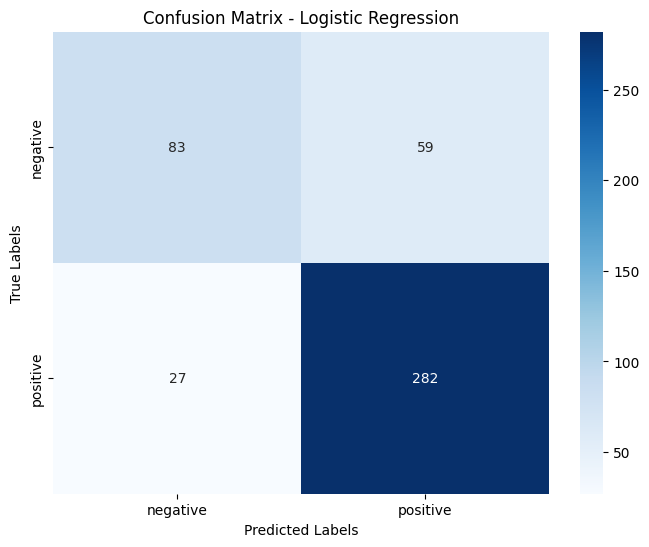

In [ ]:

# Initialize and train the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)  # Increased max_iter
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_logreg = logreg_model.predict(X_test)

# Evaluate the Logistic Regression model
print(classification_report(y_test, y_pred_logreg))

# Confusion Matrix for Logistic Regression
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
# prompt: điều chỉnh tham số của logreg

# Define the parameter grid for GridSearchCV with Logistic Regression
param_grid_logreg = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2']  # Penalty type
}

# Create a GridSearchCV object for Logistic Regression
grid_search_logreg = GridSearchCV(estimator=logreg_model,
                                 param_grid=param_grid_logreg,
                                 cv=5,  # Number of cross-validation folds
                                 scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search_logreg.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score for Logistic Regression
print("Best hyperparameters for Logistic Regression:", grid_search_logreg.best_params_)
print("Best score for Logistic Regression:", grid_search_logreg.best_score_)

# Dự đoán và đánh giá trên tập kiểm tra
best_model_logreg = grid_search_logreg.best_estimator_
y_pred_logreg = best_model_logreg.predict(X_test)
acc_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Test accuracy: {acc_logreg}")

# Đánh giá mô hình trên tập Test
print('Classification report: \n', classification_report(y_test, y_pred_logreg))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/us

Best hyperparameters for Logistic Regression: {'C': 1, 'penalty': 'l2'}
Best score for Logistic Regression: 0.7970614183915847
Test accuracy: 0.8093126385809313
Classification report: 
               precision    recall  f1-score   support

           0       0.75      0.58      0.66       142
           1       0.83      0.91      0.87       309

    accuracy                           0.81       451
   macro avg       0.79      0.75      0.76       451
weighted avg       0.80      0.81      0.80       451



In [ ]:
# Hàm tạo mô hình BiLSTM
def create_bilstm_model_tfidf(input_length):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_length,)),  # Nhận đầu vào với shape phù hợp
        tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Lớp Dense để học đặc trưng từ TF-IDF
        tf.keras.layers.Dropout(0.8),  # Dropout để tránh overfitting
        tf.keras.layers.Dense(1, activation='sigmoid')
        # Output layer cho phân loại nhị phân
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Khởi tạo mô hình
input_length = X_train.shape[1]  # Độ dài đầu vào tương ứng số cột của TF-IDF
model = create_bilstm_model_tfidf(input_length=input_length)

# # Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_val, y_val))

# Lưu mô hình tốt nhất
model.save('best_bilstm_model')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.6202 - loss: 1.7044 - val_accuracy: 0.6829 - val_loss: 0.6291
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7020 - loss: 0.6060 - val_accuracy: 0.6829 - val_loss: 0.6087
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6859 - loss: 0.6058 - val_accuracy: 0.6851 - val_loss: 0.6020
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6928 - loss: 0.5903 - val_accuracy: 0.6940 - val_loss: 0.5984
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7062 - loss: 0.5928 - val_accuracy: 0.6918 - val_loss: 0.5943
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7218 - loss: 0.5769 - val_accuracy: 0.7051 - val_loss: 0.5892
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7503 - loss: 0.5722 - val_accuracy: 0.7140 - val_loss: 0.5880
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7485 - loss: 0.5786 - val_accuracy: 0.7162 - v

Text(0, 0.5, 'Accuracy')

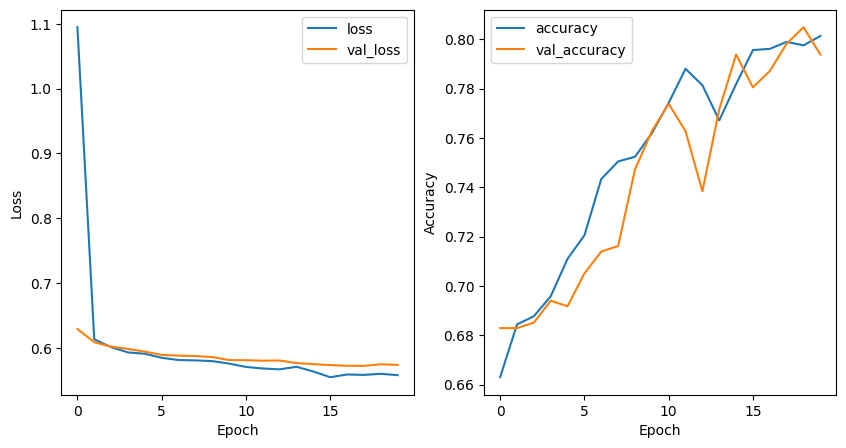

In [ ]:
# Plotting the history
metrics = history.history
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'],
		metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')